# House price regression: price prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

pd.set_option('display.max_columns', 500)

## Import data

In [24]:
df_train = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_trainset.csv")
df_train = df_train.drop(['Unnamed: 0'], axis=1)

df_test = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_testset.csv")
df_test = df_test.drop(['Unnamed: 0'], axis=1)

df_train_OHE = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_trainset_OHE.csv")
df_train_OHE = df_train_OHE.drop(['Unnamed: 0'], axis=1)

df_test_OHE = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/cleansed_testset_OHE.csv")
df_test_OHE = df_test_OHE.drop(['Unnamed: 0'], axis=1)

continuous_features = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/continuous_features.txt", 'rb'))
categorical_features = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/categorical_features.txt", 'rb'))

scaler_continuous = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/scaler_continuous.txt", 'rb'))
le_categorical = pickle.load(open("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/le_categorical.txt", 'rb'))


for feature in categorical_features:
    df_train[feature] = df_train[feature].astype('category')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.067331,3,-0.184481,-0.217879,1,1,3,3,0,4,0,5,2,2,0,5,0.646183,-0.507284,-1.046258,-0.896833,1,1,13,13,1,0.529034,2,4,2,2,4,3,2,0.581145,6,-0.293025,-0.934165,-0.443078,1,0,1,4,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,2,0.986849,6,-0.924311,3,1,0.294975,2,0.307040,0.349364,5,5,2,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-1.552184,-0.157646,8,4,0.347273
1,2,-0.873616,3,0.458190,-0.072044,1,1,3,3,0,2,0,24,1,2,0,2,-0.063185,2.188279,-0.154764,0.395604,1,1,8,8,3,-0.567016,3,4,1,2,4,1,0,1.178255,6,-0.293025,-0.629284,0.477463,1,0,1,4,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,3,-0.287758,6,0.623632,5,1,0.234953,2,0.307040,-0.058991,5,5,2,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-0.446925,0.602962,8,4,0.007288
2,3,0.067331,3,-0.055946,0.137197,1,1,0,3,0,4,0,5,2,2,0,5,0.646183,-0.507284,-0.980221,-0.848965,1,1,13,13,1,0.338903,2,4,2,2,4,2,2,0.098189,6,-0.293025,-0.287999,-0.297968,1,0,1,4,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,2,-0.287758,6,0.623632,5,1,0.290529,2,0.307040,0.627787,5,5,2,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,1.026753,-0.157646,8,4,0.536154
3,4,0.302568,3,-0.398704,-0.078385,1,1,0,3,0,0,0,6,2,2,0,5,0.646183,-0.507284,1.859351,0.682812,1,1,14,15,3,-0.567016,3,4,0,4,1,3,0,-0.494529,6,-0.293025,-0.046824,-0.669812,1,2,1,4,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,2,0.349546,6,0.623632,2,5,0.283860,3,1.619264,0.785561,5,5,2,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,-1.552184,1.363569,8,0,-0.515281
4,5,0.067331,3,0.629569,0.518903,1,1,0,3,0,2,0,15,2,2,0,5,1.355551,-0.507284,-0.947203,-0.753229,1,1,13,13,1,1.390216,2,4,2,2,4,0,2,0.469187,6,-0.293025,-0.160586,0.212184,1,0,1,4,-0.037170,1.671651,-0.101197,1.378042,1.087334,-0.249719,0.781366,1.232599,1.385655,-0.207698,2,1.624153,6,0.623632,5,1,0.288306,2,1.619264,1.685798,5,5,2,0.776967,0.540424,-0.359601,-0.103331,-0.285935,-0.06315,3,4,1,-0.089592,2.132012,-0.157646,8,4,0.869843


In [25]:
df_train_OHE.head()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,Alley_0,Alley_1,Alley_2,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_15,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Id,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Regression sale price against lot frontage

regression coefficient:  [[0.3481957]]


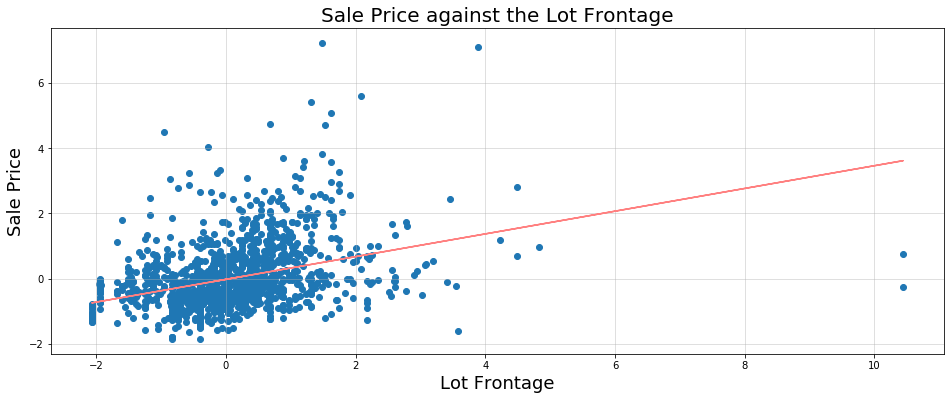

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
X, y = df_train["LotFrontage"], df_train["SalePrice"]
X, y = X[X.notnull()].values, y[X.notnull()].values
X, y = X.reshape(X.shape[0], 1), y.reshape(y.shape[0], 1)
plt.scatter(X, y)
plt.grid(alpha=.5)

reg = LinearRegression()
reg.fit(X, y)
line = reg.predict(X)

plt.plot(X, line, color=(1, .5, .5))
plt.xlabel('Lot Frontage', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Sale Price against the Lot Frontage', fontsize=20)
print('regression coefficient: ', reg.coef_)

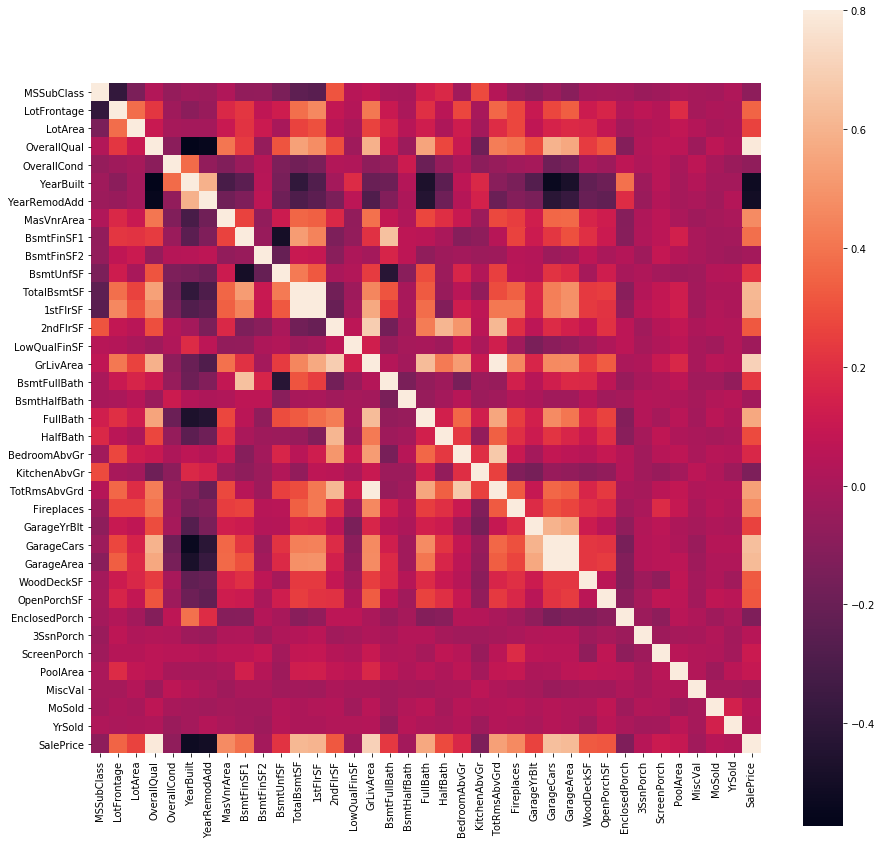

In [27]:
C_mat = (df_train[continuous_features]).corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## First model: Random Forest

In [31]:
X = df_train_OHE.drop(['Id', 'SalePrice'], axis=1)
y = df_train_OHE['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

In [32]:
rf = RandomForestRegressor(max_depth=50, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [33]:
prediction = rf.predict(X_test)

y_test_inverse = scaler_continuous['SalePrice'].inverse_transform(y_test)
log_y_test_inverse = np.log(y_test_inverse)

prediction_inverse = scaler_continuous['SalePrice'].inverse_transform(prediction)
log_prediction_inverse = np.log(prediction_inverse)
print('MSE for RF: ', mean_squared_error(log_y_test_inverse, log_prediction_inverse))

MSE for RF:  0.021256998958387403


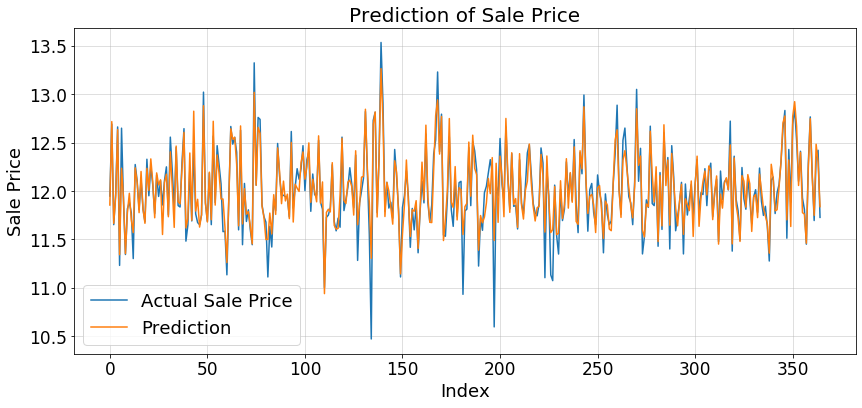

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_inverse, label='Prediction')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

## Second model: Dense Neural Network

In [120]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
optimizer = Adam(learning_rate=1e-4)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               10240     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
_________________________________________________________________


In [121]:
NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_test, y_test))

Train on 1095 samples, validate on 365 samples
Epoch 1/100
1095/1095 [==============================] - 2s 1ms/sample - loss: 0.6279 - acc: 0.0000e+00 - val_loss: 0.5251 - val_acc: 0.0000e+00
Epoch 2/100
1095/1095 [==============================] - 0s 382us/sample - loss: 0.3979 - acc: 0.0000e+00 - val_loss: 0.3553 - val_acc: 0.0000e+00
Epoch 3/100
1095/1095 [==============================] - 0s 367us/sample - loss: 0.2978 - acc: 0.0000e+00 - val_loss: 0.2701 - val_acc: 0.0000e+00
Epoch 4/100
1095/1095 [==============================] - 0s 388us/sample - loss: 0.2566 - acc: 0.0000e+00 - val_loss: 0.2495 - val_acc: 0.0000e+00
Epoch 5/100
1095/1095 [==============================] - 0s 357us/sample - loss: 0.2368 - acc: 0.0000e+00 - val_loss: 0.2380 - val_acc: 0.0000e+00
Epoch 6/100
1095/1095 [==============================] - 0s 375us/sample - loss: 0.2232 - acc: 0.0000e+00 - val_loss: 0.2276 - val_acc: 0.0000e+00
Epoch 7/100
1095/1095 [==============================] - 0s 414us/sample 

In [122]:
prediction_nn = NN_model.predict(X_test)
prediction_nn_inverse = scaler_continuous['SalePrice'].inverse_transform(prediction_nn)
log_prediction_nn_inverse = np.log(prediction_nn_inverse)
print('MSE for NN: ', mean_squared_error(log_y_test_inverse, log_prediction_nn_inverse))

MSE for NN:  0.020778761314684598


## Graphical comparison of prediction

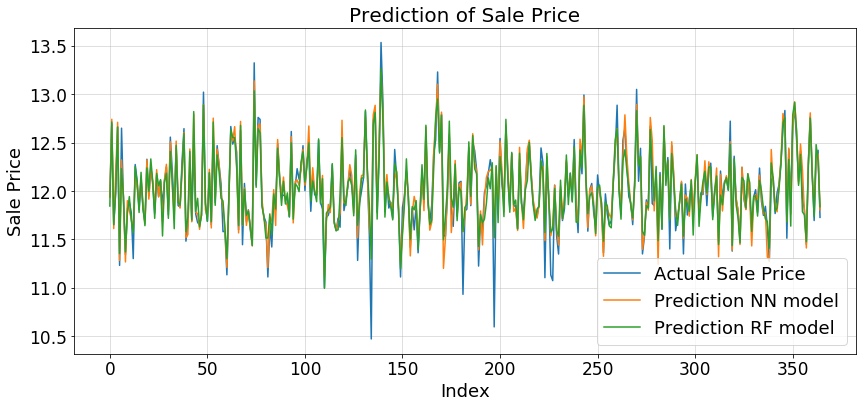

In [123]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_nn_inverse, label='Prediction NN model')
plt.plot(log_prediction_inverse, label='Prediction RF model')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

In [23]:
df_train_OHE.head()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,Alley_0,Alley_1,Alley_2,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_15,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [36]:
X, y = df_train_OHE.drop(['Id', 'SalePrice'], axis=1), df_train_OHE['SalePrice']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [43]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train , verbose=1)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
prediction_xgb_inverse = scaler_continuous['SalePrice'].inverse_transform(XGBpredictions)
log_prediction_xgb_inverse = np.log(prediction_xgb_inverse)
MAE = mean_squared_error(log_y_test_inverse , log_prediction_xgb_inverse)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.019807159715646495


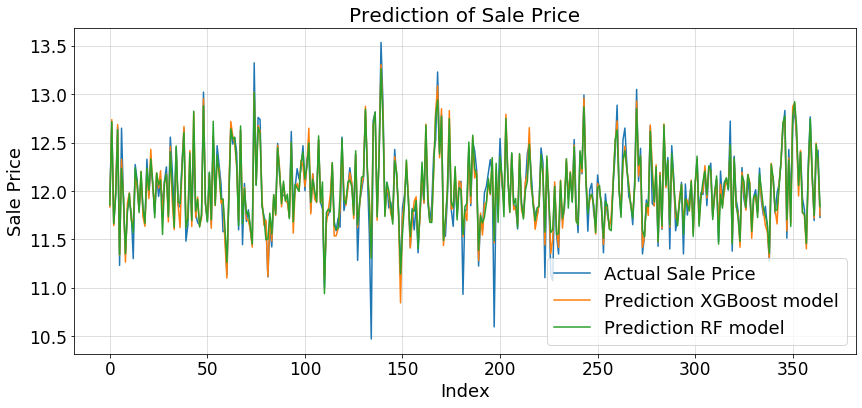

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(log_y_test_inverse, label='Actual Sale Price')
plt.plot(log_prediction_xgb_inverse, label='Prediction XGBoost model')
plt.plot(log_prediction_inverse, label='Prediction RF model')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Sale Price', fontsize=18)
plt.title('Prediction of Sale Price', fontsize = 20)
plt.grid(alpha=.5)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=18)

The neural network model provides better performances.
The same model is now trained on the whole training set, to predict the test set for submission

In [124]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
optimizer = Adam(learning_rate=1e-4)
NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['acc'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               10240     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
_________________________________________________________________


In [125]:
X_train = df_train.drop(['SalePrice', 'Id'], axis=1)
y_train = df_train['SalePrice']
NN_model.fit(X_train, y_train, epochs=100, batch_size=32)

Train on 1460 samples
Epoch 1/100
1460/1460 [==============================] - 1s 650us/sample - loss: 0.6273 - acc: 0.0000e+00
Epoch 2/100
1460/1460 [==============================] - 0s 288us/sample - loss: 0.3615 - acc: 0.0000e+00
Epoch 3/100
1460/1460 [==============================] - 0s 295us/sample - loss: 0.2697 - acc: 0.0000e+00
Epoch 4/100
1460/1460 [==============================] - 0s 291us/sample - loss: 0.2347 - acc: 0.0000e+00
Epoch 5/100
1460/1460 [==============================] - 0s 292us/sample - loss: 0.2154 - acc: 0.0000e+00
Epoch 6/100
1460/1460 [==============================] - 0s 292us/sample - loss: 0.2028 - acc: 0.0000e+00
Epoch 7/100
1460/1460 [==============================] - 0s 300us/sample - loss: 0.1948 - acc: 0.0000e+00
Epoch 8/100
1460/1460 [==============================] - 0s 297us/sample - loss: 0.1925 - acc: 0.0000e+00
Epoch 9/100
1460/1460 [==============================] - 0s 294us/sample - loss: 0.1819 - acc: 0.0000e+00
Epoch 10/100
1460/1460 [

## Submission with XGBoost prediction

In [47]:
XGBModel = XGBRegressor()
XGBModel.fit(X, y , verbose=1)

X_test_OHE = df_test_OHE.drop(['Id'], axis=1)
XGBpredictions = XGBModel.predict(X_test_OHE)
prediction_xgb_inverse = scaler_continuous['SalePrice'].inverse_transform(XGBpredictions)

In [48]:
submission =pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = prediction_xgb_inverse
submission.head()

,Id,SalePrice
0,1461,130804.890625
1,1462,162521.328125
2,1463,191522.281250
3,1464,197519.343750
4,1465,188635.437500


## Preparation of submission with NN

In [126]:
X_test = df_test.drop(['Id'], axis=1)
final_prediction = NN_model.predict(X_test)
final_prediction = scaler_continuous['SalePrice'].inverse_transform(final_prediction)
submission =pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = final_prediction
submission.head()

,Id,SalePrice
0,1461,114583.906250
1,1462,145467.750000
2,1463,183216.906250
3,1464,201367.484375
4,1465,178395.093750


## CSV submission

In [49]:
vg_submission = submission.to_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/vg_submission3_xgb.csv", index=False)

In [50]:
sub = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/house-prices-advanced-regression-techniques/vg_submission3_xgb.csv")

In [51]:
sub.head()

,Id,SalePrice
0,1461,130804.89
1,1462,162521.33
2,1463,191522.28
3,1464,197519.34
4,1465,188635.44
